In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
from random import random
import math

MAX_AUDIO_DURATION = 0.5
MAX_SAMPLE_COUNT_PER_ARTIST = 100
MAX_SAMPLE_COMPARISON_COUNT = 50

apppath = os.path.expanduser('/Users/andrusasumets/projects/experiments/pacemaker/')
processedpath = os.path.join(apppath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
extensionpath = os.path.join(apppath, 'pacemaker WatchKit Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/downloads/')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
f = open(apppath + 'artists.txt')
artists = ''.join(f.readlines()).strip().replace('\n', ',').split(',')
print('artists:', len(artists))
print(artists)

artists: 53
['gameaudio', 'egolessdub', 'batchku', 'dneproman', 'walter-odington', 'errorcell', 'drfx', 'adcbicycle', 'potentjello', 'phr4kture', 'rutgermuller', 'sturmankin', 'ianstargem', 'pjcohen', 'the-very-real-horst', 'felix-blume', 'firnwald', 'suicidity', 'veiler', 'ecodtr', 'martian', 'kanito', 'soneproject', 'cormi', 'john-scott', 'kyles', 'rucisko', 'spankmyfilth', 'samplecat', 'schafferdavid', 'galeku', 'jjbbllkk', 'hello-flowers', 'psysofastia', 'growingup', 'adcbicycle', 'ianstargem', 'ecodtr', 'owlstorm', 'nox-sound', 'chaad', 'giomilko', 'carlmartin', 'art6nik', 'unfav', 'deadrobotmusic', 'kreutzkamp', 'staticpony1', 'the-sacha', 'vinjatovix', 'owstu', 'phantastonia', 'cpolcyn']


In [3]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

fileformats {'wav': 43017, 'mp3': 2756, 'aiff': 17770, 'flac': 2696, 'ogg': 588, 'm4a': 141, 'crdownload': 7, 'DS_Store': 1}
all_filenames: 66976


In [4]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [5]:
def process(command):
    subprocess.check_output(command)

sample_artists = {}
sample_durations = {}
res = []

for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat

        #if fileartist not in artists:
            #continue

        if fileartist not in sample_artists:
            sample_artists[fileartist] = 0

        sample_artists[fileartist] = sample_artists[fileartist] + 1

        if sample_artists[fileartist] >= MAX_SAMPLE_COUNT_PER_ARTIST:
            continue

        soxi_out = create_or_read_file(['soxi', '-D', librarypath + filename], soxipath + fileid + '.soxi')
        if not soxi_out:
            continue

        sample_duration = float(soxi_out)
        if sample_duration > MAX_AUDIO_DURATION:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        sample_durations[fileid] = sample_duration
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))
print(sample_artists)

['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634258__darcyadam__28-overtone-flutter.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/flehxx1l.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634258__darcyadam__28-overtone-flutter.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634258__darcyadam__28-overtone-flutter.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139582__gherat__button-master-006.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/nlz0wua1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139582__gherat__button-master-006.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139582__gherat__button-master-006.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459223__soneproject__snare0dc5.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9dpyf1o9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459223__soneproject__snare0dc5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459223__soneproject__snare0dc5.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183332__unfa__beatbox-shaker-take-5.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-38.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_9xu5ss9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-38.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183332__unfa__beatbox-shaker-take-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183332__unfa__beatbox-shaker-take-5.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183358__unfa__beatbox-hihat-take-32.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k56hl8jx.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183358__unfa__beatbox-hihat-take-32.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183358__unfa__beatbox-hihat-take-32.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457699__soneproject__noisemaker-sawc4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1vzvk2nr.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457699__soneproject__noisemaker-sawc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457699__soneproject__noisemaker-sawc4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441724__soundx360__drum-pad1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441724__soundx360__drum-pad1.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441724__soundx360__drum-pad1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441724__soundx360__drum-pad1.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560803__miles-thompson__accordion-minor-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560803__miles-thompson__accordion-minor-ab.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560803__miles-thompson__accordion-minor-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560803__miles-thompson__accordion-minor-ab.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183367__unfa__beatbox-hihat-take-6.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ook4yqef.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183367__unfa__beatbox-hihat-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183367__unfa__beatbox-hihat-take-6.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459232__soneproject__snare0cc-5.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ccrxy115.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459232__soneproject__snare0cc-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459232__soneproject__snare0cc-5.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534226__pbimal__stock-water-bubbling-02.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n_jdmgob.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534226__pbimal__stock-water-bubbling-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534226__pbimal__stock-water-bubbling-02.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49062__suspiciononline__mocasg-bd02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49062__suspiciononline__mocasg-bd02.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/164620__deleted-user-2104797__car-interior-driving-2.wav': WAVE file fmt with padded samples is not supported yet


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49062__suspiciononline__mocasg-bd02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49062__suspiciononline__mocasg-bd02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183361__unfa__beatbox-hihat-take-4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/3ssg5bgn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-42.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183361__unfa__beatbox-hihat-take-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183361__unfa__beatbox-hihat-take-4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441723__soundx360__drum-111.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441723__soundx360__drum-111.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441723__soundx360__drum-111.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441723__soundx360__drum-111.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60001__qubodup__air-cutting-14.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8y4_xzt7.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-28.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60001__qubodup__air-cutting-14.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634266__darcyadam__2-kick-tone-gen-tape.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ln3lefty.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634266__darcyadam__2-kick-tone-gen-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634266__darcyadam__2-kick-tone-gen-tape.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592465__baconation__snap-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592465__baconation__snap-1.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592465__baconation__snap-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592465__baconation__snap-1.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422393__soneproject__76.flac']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tfhm1yx1.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422393__soneproject__76.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422393__soneproject__76.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422349__soneproject__82.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0c2prkzn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422349__soneproject__82.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422349__soneproject__82.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183365__unfa__beatbox-hihat-take-8.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-57.35:measured_lra=0.0:measured_tp=-46.26:measured_thresh=-67.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6akjrg6n.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-57.35:measured_lra=0.0:measured_tp=-46.26:measured_thresh=-67.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183365__unfa__beatbox-hihat-take-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183365__unfa__beatbox-hihat-take-8.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48063__suspiciononline__2-9-2008-detritus7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48063__suspiciononline__2-9-2008-detritus7.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48063__suspiciononline__2-9-2008-detritus7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48063__suspiciononline__2-9-2008-detritus7.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459302__soneproject__hat47b-9.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-15.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s020sj3g.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-15.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459302__soneproject__hat47b-9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459302__soneproject__hat47b-9.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67659__qubodup__voice-male-radio-roger-5.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.95:measured_lra=0.0:measured_tp=-3.32:measured_thresh=-22.95:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ftyvso8i.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.95:measured_lra=0.0:measured_tp=-3.32:measured_thresh=-22.95:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67659__qubodup__voice-male-radio-roger-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67659__qubodup__voice-male-radio-roger-5.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139606__gherat__button-master-063.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jm7fcf0l.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139606__gherat__button-master-063.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139606__gherat__button-master-063.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512391__kievinay__claps-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512391__kievinay__claps-03.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512391__kievinay__claps-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512391__kievinay__claps-03.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457674__soneproject__helm-squarec4.flac']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0onqe1mb.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457674__soneproject__helm-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457674__soneproject__helm-squarec4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183355__unfa__beatbox-hihat-take-3.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cfz3swa_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-37.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183355__unfa__beatbox-hihat-take-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183355__unfa__beatbox-hihat-take-3.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139602__gherat__button-master-077.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.89:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qiohtt2v.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.89:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139602__gherat__button-master-077.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139602__gherat__button-master-077.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646704__pbimal__finger-snap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646704__pbimal__finger-snap.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646704__pbimal__finger-snap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646704__pbimal__finger-snap.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459259__soneproject__brushride1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-40.45:measured_lra=0.0:measured_tp=-27.02:measured_thresh=-50.45:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tg7jgj7_.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-40.45:measured_lra=0.0:measured_tp=-27.02:measured_thresh=-50.45:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459259__soneproject__brushride1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459259__soneproject__brushride1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459231__soneproject__snare04e-4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/uvvqg0sn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459231__soneproject__snare04e-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459231__soneproject__snare04e-4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203467__tesabob2001__b5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203467__tesabob2001__b5.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203467__tesabob2001__b5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203467__tesabob2001__b5.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353826__magnesus__dice29.flac']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=1.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0vppyeuv.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=1.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353826__magnesus__dice29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353826__magnesus__dice29.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395338__ihitokage__swish-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395338__ihitokage__swish-1.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395338__ihitokage__swish-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395338__ihitokage__swish-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457672__soneproject__helm-4stepsc2.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/eu2a0rzt.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457672__soneproject__helm-4stepsc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457672__soneproject__helm-4stepsc2.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422394__soneproject__75.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ofxsu92a.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422394__soneproject__75.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422394__soneproject__75.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634257__darcyadam__30-broken-tape-bass.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_blr0mfh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634257__darcyadam__30-broken-tape-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634257__darcyadam__30-broken-tape-bass.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634898__darcyadam__bass-warp-15-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/iy3os7ce.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634898__darcyadam__bass-warp-15-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634898__darcyadam__bass-warp-15-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459301__soneproject__hat46a9.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yjnp7g5y.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459301__soneproject__hat46a9.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459301__soneproject__hat46a9.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_f_1hpn3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49031__suspiciononline__moca-ching.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49031__suspiciononline__moca-ching.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49031__suspiciononline__moca-ching.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49031__suspiciononline__moca-ching.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pa

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0fzc78br.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_m

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634904__darcyadam__kick-3-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634904__darcyadam__kick-3-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139635__gherat__button-master-043.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ei36w77u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139635__gherat__button-master-043.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139635__gherat__button-master-043.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203471__tesabob2001__e4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203471__tesabob2001__e4.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203471__tesabob2001__e4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203471__tesabob2001__e4.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456457__soneproject__clap1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1w4hqj2p.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456457__soneproject__clap1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456457__soneproject__clap1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395354__ihitokage__hand-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395354__ihitokage__hand-4.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395354__ihitokage__hand-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395354__ihitokage__hand-4.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535241__pbimal__stock-tissue-paper-pulling-00.flac']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b5jv266n.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.88:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535241__pbimal__stock-tissue-paper-pulling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535241__pbimal__stock-tissue-paper-pulling-00.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457686__soneproject__zyn-sinec2.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/a9_t3ub9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457686__soneproject__zyn-sinec2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457686__soneproject__zyn-sinec2.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456477__soneproject__kikr7.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-10.35:measured_lra=0.0:measured_tp=-0.71:measured_thresh=-20.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/agxp62d1.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-10.35:measured_lra=0.0:measured_tp=-0.71:measured_thresh=-20.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456477__soneproject__kikr7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456477__soneproject__kikr7.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60012__qubodup__swing-25.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cp83_c5s.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60012__qubodup__swing-25.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60012__qubodup__swing-25.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634896__darcyadam__bass-warp-1-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/shvwx6iy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634896__darcyadam__bass-warp-1-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634896__darcyadam__bass-warp-1-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59998__qubodup__weapon-swing-air-sound.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/t9qb_2nx.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59998__qubodup__weapon-swing-air-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59998__qubodup__weapon-swing-air-sound.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139607__gherat__button-master-061.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/a2kapgcf.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.42:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139607__gherat__button-master-061.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139607__gherat__button-master-061.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457690__soneproject__obxd-squarec4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/t5o38n4f.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.54:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457690__soneproject__obxd-squarec4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457690__soneproject__obxd-squarec4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wshwbu0b.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-10.25:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-20.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186275__unfa__hihat-09.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fjat61v1.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186275__unfa__hihat-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186275__unfa__hihat-09.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545344__stwime__down.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545344__stwime__down.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545344__stwime__down.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545344__stwime__down.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559418__crabflag__pss560-shaker.aiff']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ws932ymm.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559418__crabflag__pss560-shaker.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559418__crabflag__pss560-shaker.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9md91jck.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559403__crabflag__pss560-agogo-hi.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/89ar695t.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559403__crabflag__pss560-agogo-hi.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559403__crabflag__pss560-agogo-hi.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459253__soneproject__cymbals73.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0xa233c8.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459253__soneproject__cymbals73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459253__soneproject__cymbals73.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456454__soneproject__hardkik1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.35:measured_lra=0.0:measured_tp=-1.38:measured_thresh=-19.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f8lsn9oq.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.35:measured_lra=0.0:measured_tp=-1.38:measured_thresh=-19.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456454__soneproject__hardkik1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456454__soneproject__hardkik1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459307__soneproject__hat4f.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tqbdf5zj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wd

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459307__soneproject__hat4f.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459307__soneproject__hat4f.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559408__crabflag__pss560-perc1-processed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/g5ycytv4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559408__crabflag__pss560-perc1-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559408__crabflag__pss560-perc1-processed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634268__darcyadam__25-peak-ride-tape.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lo77ty9y.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634268__darcyadam__25-peak-ride-tape.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634268__darcyadam__25-peak-ride-tape.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634247__darcyadam__1-panasonic-kick.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xosheco9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634247__darcyadam__1-panasonic-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634247__darcyadam__1-panasonic-kick.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395350__ihitokage__slap-1.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395350__ihitokage__slap-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459275__soneproject__hat6b.flac']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cqyys6r8.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459275__soneproject__hat6b.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459275__soneproject__hat6b.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128271__rebeat__resonance.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/u32qx14y.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128271__rebeat__resonance.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128271__rebeat__resonance.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422347__soneproject__88.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.65:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-21.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sauai182.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.65:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-21.65:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422347__soneproject__88.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422347__soneproject__88.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60009__qubodup__swosh-22.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/iuvqc8hi.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60009__qubodup__swosh-22.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459222__soneproject__snare0ed-5.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/uwtq92gm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459222__soneproject__snare0ed-5.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459222__soneproject__snare0ed-5.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457671__soneproject__helm-4stepsc4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/665l2n5h.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457671__soneproject__helm-4stepsc4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457671__soneproject__helm-4stepsc4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534229__pbimal__stock-water-bubbling-07.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-26.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qhwxnngc.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-26.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534229__pbimal__stock-water-bubbling-07.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534229__pbimal__stock-water-bubbling-07.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139591__gherat__button-master-013.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/aj4pgn__.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.79:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139591__gherat__button-master-013.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139591__gherat__button-master-013.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456459__soneproject__hardkik4.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-8.05:measured_lra=0.0:measured_tp=-1.46:measured_thresh=-18.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/r7of3884.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-8.05:measured_lra=0.0:measured_tp=-1.46:measured_thresh=-18.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456459__soneproject__hardkik4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456459__soneproject__hardkik4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422356__soneproject__91.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/p2wlnsql.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422356__soneproject__91.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422356__soneproject__91.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634259__darcyadam__29-unfair-light-hit.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/hp429yet.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634259__darcyadam__29-unfair-light-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634259__darcyadam__29-unfair-light-hit.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183316__unfa__beatbox-snare-take-17.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-25.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rj1t_ng9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-25.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183316__unfa__beatbox-snare-take-17.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183316__unfa__beatbox-snare-take-17.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560825__miles-thompson__accordion-major-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560825__miles-thompson__accordion-major-eb.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560825__miles-thompson__accordion-major-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560825__miles-thompson__accordion-major-eb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49034__suspiciononline__moca-fxs-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49034__sus

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49034__suspiciononline__moca-fxs-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49034__suspiciononline__moca-fxs-02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634254__darcyadam__35-snare-lower-pitch-layer.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ir0wru3m.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634254__darcyadam__35-snare-lower-pitch-layer.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634254__darcyadam__35-snare-lower-pitch-layer.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560796__miles-thompson__accordion-minor-d.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560796__miles-thompson__accordion-minor-d.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560796__miles-thompson__accordion-minor-d.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560796__miles-thompson__accordion-minor-d.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395334__ihitokage__woosh-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395334__ihitokage__woosh-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395334__ihitokage__woosh-2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634249__darcyadam__15-panasonic-slidein-snare-1.aiff']


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bmy2kbwr.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634249__darcyadam__15-panasonic-slidein-snare-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634249__darcyadam__15-panasonic-slidein-snare-1.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60014__qubodup__swosh-27.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/m5jnayf6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60014__qubodup__swosh-27.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422396__soneproject__80.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-21.75:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-31.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w5njvo6r.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-21.75:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-31.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422396__soneproject__80.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422396__soneproject__80.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139630__gherat__button-master-058.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pmt7vpe2.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139630__gherat__button-master-058.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139630__gherat__button-master-058.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186270__unfa__hihat-08.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gh3563no.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c000

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/186270__unfa__hihat-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/186270__unfa__hihat-08.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48066__suspiciononline__2-9-2008-guitar-says-go.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48066__suspiciononline__2-9-2008-guitar-says-go.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48066__suspiciononline__2-9-2008-guitar-says-go.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48066__suspiciononline__2-9-2008-guitar-says-go.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459260__soneproject__cymbals28e-7.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.64:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kcvs99kw.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.64:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459260__soneproject__cymbals28e-7.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459260__soneproject__cymbals28e-7.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634906__darcyadam__kick-10-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0kwuha8a.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/va

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634906__darcyadam__kick-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634906__darcyadam__kick-10-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395333__ihitokage__grab-2.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395333__ihitokage__grab-2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67658__qubodup__voice-male-radio-roger-4.flac']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-11.25:measured_lra=0.0:measured_tp=-3.51:measured_thresh=-21.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rnvarh_o.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-11.25:measured_lra=0.0:measured_tp=-3.51:measured_thresh=-21.25:linear=true:print_format=json[norm0]', '-map_metadata', '0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67658__qubodup__voice-male-radio-roger-4.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67658__qubodup__voice-male-radio-roger-4.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560845__miles-thompson__accordion-major-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560845__miles-thompson__accordion-major-g.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560845__miles-thompson__accordion-major-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560845__miles-thompson__accordion-major-g.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367286

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/i6yir8aw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367286__dinmonger__batteryclack6.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367286__dinmonger__batteryclack6.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536766__egomassive__thud.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536766__egomassive__thud.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536766__egomassive__thud.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536766__egomassive__thud.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252172__pepingrillin__hitground3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252172__pepingrillin__hitground3.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252172__pepingrillin__hitground3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252172__pepingrillin__hitground3.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646759__pbimal__bottle-pop-short.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.66:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/098qvz7u.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.66:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646759__pbimal__bottle-pop-short.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646759__pbimal__bottle-pop-short.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422386__soneproject__72.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gdt53xyo.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422386__soneproject__72.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422386__soneproject__72.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139583__gherat__button-master-005.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bxwu3ild.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.53:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139583__gherat__button-master-005.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139583__gherat__button-master-005.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457679__soneproject__zyn-powerc2.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ogo_l2wl.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/457679__soneproject__zyn-powerc2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/457679__soneproject__zyn-powerc2.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634264__darcyadam__21-open-hat-noise.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/c0bcg7fy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634264__darcyadam__21-open-hat-noise.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634264__darcyadam__21-open-hat-noise.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534225__pbimal__stock-water-bubbling-03.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4hn_3wib.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.93:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534225__pbimal__stock-water-bubbling-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534225__pbimal__stock-water-bubbling-03.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367277__dinmonger__batteryclack12.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.09:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x6t6pge4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.09:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367277__dinmonger__batteryclack12.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367277__dinmonger__batteryclack12.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459305__soneproject__hat4d.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-29.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lhp9x8ei.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-29.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wd

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459305__soneproject__hat4d.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459305__soneproject__hat4d.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459268__soneproject__kick20g6.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-26.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qfwwahrs.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-16.25:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-26.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459268__soneproject__kick20g6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459268__soneproject__kick20g6.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545373__stwime__up3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545373__stwime__up3.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545373__stwime__up3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545373__stwime__up3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353825__magnesus__dice28tick.flac']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/numks_cu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353825__magnesus__dice28tick.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353825__magnesus__dice28tick.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646758__pbimal__bottle-popping-with-thumb.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/qxlwwq88.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/va

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646758__pbimal__bottle-popping-with-thumb.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646758__pbimal__bottle-popping-with-thumb.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/217433__unfa__hunger-noises-01.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-29.15:measured_lra=0.0:measured_tp=-14.82:measured_thresh=-39.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ii_ckxuf.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-29.15:measured_lra=0.0:measured_tp=-14.82:measured_thresh=-39.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/217433__unfa__hunger-noises-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/217433__unfa__hunger-noises-01.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634895__darcyadam__bass-warp-10-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.55:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.55:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mwuxr4m3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.55:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-26.55:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634895__darcyadam__bass-warp-10-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634895__darcyadam__bass-warp-10-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560830__miles-thompson__accordion-minor-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560830__miles-thompson__accordion-minor-g.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560830__miles-thompson__accordion-minor-g.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560830__miles-thompson__accordion-minor-g.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/193418__unfa__empty.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.46:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/eki6g365.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.46:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0000g

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/193418__unfa__empty.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/193418__unfa__empty.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-4.31:measured_thresh=-29.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kwdhkuoe.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-4.31:measured_thresh=-29.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/249336__cpolcyn__bwana-kumala-ceng-ceng-11.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139575__gherat__button-master-024.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.22:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/3i9co1m7.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.22:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139575__gherat__button-master-024.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139575__gherat__button-master-024.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395341__ihitokage__woosh-6.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395341__ihitokage__woosh-6.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395341__ihitokage__woosh-6.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395341__ihitokage__woosh-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422392__soneproject__73.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.85:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-26.85:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/oxm4jrae.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-16.85:measured_lra=0.0:measured_tp=-0.99:measured_thresh=-26.85:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422392__soneproject__73.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422392__soneproject__73.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139600__gherat__button-master-028.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/snplww_u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139600__gherat__button-master-028.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139600__gherat__button-master-028.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634262__darcyadam__31-crap-trans-bass.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kbb5fyao.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634262__darcyadam__31-crap-trans-bass.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634262__darcyadam__31-crap-trans-bass.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459237__soneproject__cymbals37g-8.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7255g2pb.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/459237__soneproject__cymbals37g-8.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/459237__soneproject__cymbals37g-8.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560823__miles-thompson__accordion-major-e.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560823__miles-thompson__accordion-major-e.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560823__miles-thompson__accordion-major-e.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560823__miles-thompson__accordion-major-e.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456472__soneproject__kikr6.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-14.65:measured_lra=0.0:measured_tp=-0.57:measured_thresh=-24.65:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/p81lidb3.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-14.65:measured_lra=0.0:measured_tp=-0.57:measured_thresh=-24.65:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/456472__soneproject__kikr6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/456472__soneproject__kikr6.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559407__crabflag__pss560-hh-closed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.72:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gjqs17ua.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.72:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559407__crabflag__pss560-hh-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559407__crabflag__pss560-hh-closed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/612678__foleyhaven__pig-grunt-03.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x6ggqcl2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/612678__foleyhaven__pig-grunt-03.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/612678__foleyhaven__pig-grunt-03.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422344__soneproject__90.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.15:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-22.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ulct_e92.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-12.15:measured_lra=0.0:measured_tp=-1.0:measured_thresh=-22.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/422344__soneproject__90.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/422344__soneproject__90.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634245__darcyadam__11-panasonic-lo-clap.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wt9q58_d.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634245__darcyadam__11-panasonic-lo-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634245__darcyadam__11-panasonic-lo-clap.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139578__gherat__button-master-002.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/npgwbp0n.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139578__gherat__button-master-002.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139578__gherat__button-master-002.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183313__unfa__beatbox-snare-take-18.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-48.35:measured_lra=0.0:measured_tp=-32.5:measured_thresh=-58.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/__ijbj5b.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-48.35:measured_lra=0.0:measured_tp=-32.5:measured_thresh=-58.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183313__unfa__beatbox-snare-take-18.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183313__unfa__beatbox-snare-take-18.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634894__darcyadam__bass-warp-11-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zdviz3fr.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634894__darcyadam__bass-warp-11-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634894__darcyadam__bass-warp-11-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559421__crabflag__pss560-rim-shot.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/rnfyltxp.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559421__crabflag__pss560-rim-shot.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559421__crabflag__pss560-rim-shot.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/11124__jnr-hacksaw__chunk-reverse-hit.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4ql3bkzy.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/11124__jnr-hacksaw__chunk-reverse-hit.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/11124__jnr-hacksaw__chunk-reverse-hit.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395342__ihitokage__woosh-7.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395342__ihitokage__woosh-7.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395342__ihitokage__woosh-7.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395342__ihitokage__woosh-7.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634256__darcyadam__3-uh-hit.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/e7spe8h_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634256__darcyadam__3-uh-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634256__darcyadam__3-uh-hit.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634893__darcyadam__bass-warp-12-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zsfj8t31.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634893__darcyadam__bass-warp-12-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634893__darcyadam__bass-warp-12-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67653__qubodup__voice-male-radio-right-1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/hprsd1ex.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67653__qubodup__voice-male-radio-right-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67653__qubodup__voice-male-radio-right-1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139576__gherat__button-master-004.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/nhzrhdi_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.5:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139576__gherat__button-master-004.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139576__gherat__button-master-004.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545362__stwime__friendly.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545362__stwime__friendly.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545362__stwime__friendly.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545362__stwime__friendly.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183324__unfa__beatbox-kick-take-29.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-45.25:measured_lra=0.0:measured_tp=-31.58:measured_thresh=-55.25:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tpv78hk6.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-45.25:measured_lra=0.0:measured_tp=-31.58:measured_thresh=-55.25:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183324__unfa__beatbox-kick-take-29.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183324__unfa__beatbox-kick-take-29.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592457__baconation__snap-5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592457__baconation__snap-5.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592457__baconation__snap-5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592457__baconation__snap-5.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367280__dinmonger__batteryclack1.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.49:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w_ddhplt.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.49:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367280__dinmonger__batteryclack1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367280__dinmonger__batteryclack1.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139632__gherat__button-master-056.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.76:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/s3xz26_j.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.76:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139632__gherat__button-master-056.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139632__gherat__button-master-056.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139636__gherat__button-master-042.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.14:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cpqkda87.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.14:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139636__gherat__button-master-042.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139636__gherat__button-master-042.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534605__pbimal__stock-whistle-02.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tpdmtwv9.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534605__pbimal__stock-whistle-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534605__pbimal__stock-whistle-02.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139597__gherat__button-master-025.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b_mxiz22.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139597__gherat__button-master-025.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139597__gherat__button-master-025.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535957__pbimal__rubber-01.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zp6vgn0f.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhh

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535957__pbimal__rubber-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535957__pbimal__rubber-01.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139617__gherat__button-master-039.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/x_e01qip.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139617__gherat__button-master-039.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139617__gherat__button-master-039.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cqyve5vm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646757__pbimal__glass-base-collision-02.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646757__pbimal__glass-base-collision-02.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/646757__pbimal__glass-base-collision-02.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/646757__pbimal__glass-base-collision-02.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139594__gherat__b

ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.59:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/i61gtpxm.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.59:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139594__gherat__button-master-018.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139594__gherat__button-master-018.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534228__pbimal__stock-water-bubbling-00.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/txscc2zp.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534228__pbimal__stock-water-bubbling-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534228__pbimal__stock-water-bubbling-00.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367278__dinmonger__batteryclack11.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/uufwum63.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.31:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367278__dinmonger__batteryclack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367278__dinmonger__batteryclack11.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537938__belanhud__suck.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/537938__belanhud__suck.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/537938__belanhud__suck.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/537938__belanhud__suck.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407465__loyalty-freak-music__cancel.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407465__loyalty-freak-music__cancel.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49063__suspiciononline__mocasg-bd03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49063__suspiciononline__mocasg-bd03.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49063__suspiciononline__mocasg-bd03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49063__suspiciononline__mocasg-bd03.mp3']' returned non-zero exit status 1

ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539401__eldiariosonoro__encender-fogon-g5.wav': WAVE: RIFF header not found


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559406__crabflag__pss560-hh-open.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/l6e91nxg.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.99:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559406__crabflag__pss560-hh-open.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559406__crabflag__pss560-hh-open.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139616__gherat__button-master-040.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.27:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fm2ed02u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.27:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139616__gherat__button-master-040.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139616__gherat__button-master-040.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139613__gherat__button-master-037.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8gv3aqqh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139613__gherat__button-master-037.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139613__gherat__button-master-037.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139638__gherat__button-master-048.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/t2jdxh6l.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139638__gherat__button-master-048.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139638__gherat__button-master-048.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634903__darcyadam__kick-9-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/a4zekcci.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634903__darcyadam__kick-9-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634903__darcyadam__kick-9-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167328__willy-ineedthatapp-com__droplet-bad.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167328__willy-ineedthatapp-com__droplet-bad.mp3']


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167328__willy-ineedthatapp-com__droplet-bad.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167328__willy-ineedthatapp-com__droplet-bad.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49041__suspiciononline__moca-style-basedrum-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49041__suspiciononline__moca-style-basedrum-01.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49041__suspiciononline__moca-style-basedrum-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49041__suspiciononline__moca-style-basedrum-01.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531852__tissman__menu-click-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531852__tissman__menu-click-1.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531852__tissman__menu-click-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531852__tissman__menu-click-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128270__rebeat__sharp-hit.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/o3zrqq47.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/128270__rebeat__sharp-hit.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/128270__rebeat__sharp-hit.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367283__dinmonger__batteryclack3.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yiwdv55u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-17.68:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367283__dinmonger__batteryclack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367283__dinmonger__batteryclack3.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592460__baconation__snap-8.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592460__baconation__snap-8.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592460__baconation__snap-8.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592460__baconation__snap-8.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/113197__victormalloy__ignition-mustang.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-31.15:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-41.15:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fezz4yyo.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-31.15:measured_lra=0.0:measured_tp=-13.22:measured_thresh=-41.15:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/113197__victormalloy__ignition-mustang.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/113197__victormalloy__ignition-mustang.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139608__gherat__button-master-034.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lbvgmmql.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.17:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139608__gherat__button-master-034.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139608__gherat__button-master-034.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139581__gherat__button-master-007.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/y7cpnmyp.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139581__gherat__button-master-007.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139581__gherat__button-master-007.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183322__unfa__beatbox-kick-take-27.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=22.95:measured_i=-42.85:measured_lra=0.0:measured_tp=-20.47:measured_thresh=-52.85:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zzbcl6w2.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=22.95:measured_i=-42.85:measured_lra=0.0:measured_tp=-20.47:measured_thresh=-52.85:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183322__unfa__beatbox-kick-take-27.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183322__unfa__beatbox-kick-take-27.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183329__unfa__beatbox-shaker-take-6.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-36.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/q9rzb209.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-36.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/183329__unfa__beatbox-shaker-take-6.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/183329__unfa__beatbox-shaker-take-6.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395332__ihitokage__grab-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395332__ihitokage__grab-3.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395332__ihitokage__grab-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395332__ihitokage__grab-3.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49035__suspiciononline__moca-fxs-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49035__suspiciononline__moca-fxs-03.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49035__suspiciononline__moca-fxs-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49035__suspiciononline__moca-fxs-03.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139580__gherat__button-master-008.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/g4p3gfqy.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139580__gherat__button-master-008.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139580__gherat__button-master-008.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139637__gherat__button-master-041.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kwpqqtay.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139637__gherat__button-master-041.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139637__gherat__button-master-041.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139619__gherat__button-master-073.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w3779ve_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139619__gherat__button-master-073.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139619__gherat__button-master-073.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139596__gherat__button-master-026.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2bftkup_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139596__gherat__button-master-026.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139596__gherat__button-master-026.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441729__soundx360__drum-pad2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441729__soundx360__drum-pad2.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441729__soundx360__drum-pad2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441729__soundx360__drum-pad2.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67664__qubodup__voice-male-radio-smoke-em-1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-13.05:measured_lra=0.0:measured_tp=-1.7:measured_thresh=-23.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1wgawrib.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-13.05:measured_lra=0.0:measured_tp=-1.7:measured_thresh=-23.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67664__qubodup__voice-male-radio-smoke-em-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67664__qubodup__voice-male-radio-smoke-em-1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634265__darcyadam__20-pitched-hat-closed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mvl9huqu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.12:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634265__darcyadam__20-pitched-hat-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634265__darcyadam__20-pitched-hat-closed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395351__ihitokage__woosh-3.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/583309__proxmo-kashacir__aaaaaaaah.aiff': AIFF header does not begin with magic word `FORM'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634899__darcyadam__bass-warp-14-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k2k53bzz.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634899__darcyadam__bass-warp-14-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634899__darcyadam__bass-warp-14-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139612__gherat__button-master-038.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.58:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/k7zuf27u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.58:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139612__gherat__button-master-038.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139612__gherat__button-master-038.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/556259__pbimal__cooker-sliding.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.97:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/39mzk3sj.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.97:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/556259__pbimal__cooker-sliding.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/556259__pbimal__cooker-sliding.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560797__miles-thompson__accordion-major-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560797__miles-thompson__accordion-major-bb.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560797__miles-thompson__accordion-major-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560797__miles-thompson__accordion-major-bb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139579__gherat__button-master-001.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/0y5cxhu3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139579__gherat__button-master-001.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139579__gherat__button-master-001.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395367__ihitokage__swish-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395367__ihitokage__swish-2.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395367__ihitokage__swish-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395367__ihitokage__swish-2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634253__darcyadam__17-panasonic-mech-flam.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/30jm7yvn.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634253__darcyadam__17-panasonic-mech-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634253__darcyadam__17-panasonic-mech-flam.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49061__suspiciononline__mocasg-bd01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49061__suspiciononline__mocasg-bd01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49061__suspiciononline__mocasg-bd01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49061__suspiciononline__mocasg-bd01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545363__stwime__friendly.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545363__stwime__friendly.mp3']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545363__stwime__friendly.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545363__stwime__friendly.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203463__tesabob2001__b3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203463__tesabob2001__b3.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203463__tesabob2001__b3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203463__tesabob2001__b3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458660__jorgerosa__ui-typing.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458660__jorgerosa__ui-typing.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458660__jorgerosa__ui-typing.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458660__jorgerosa__ui-typing.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555529__stwime__fast-knock.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555529__stwime__fast-knock.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555529__stwime__fast-knock.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555529__stwime__fast-knock.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/104022__rutgermuller__piano-keys-cover-closed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.95:measured_lra=0.0:measured_tp=0.57:measured_thresh=-24.77:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/fhm4ksp9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-11.95:measured_lra=0.0:measured_tp=0.57:measured_thresh=-24.77:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/104022__rutgermuller__piano-keys-cover-closed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/104022__rutgermuller__piano-keys-cover-closed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545354__stwime__pan3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545354__stwime__pan3.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545354__stwime__pan3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545354__stwime__pan3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545348__stwime__pan2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545348__stwime__pan2.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545348__stwime__pan2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545348__stwime__pan2.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60003__qubodup__loud-swosh-16.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vkvssrf7.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-18.05:measured_lra=0.0:measured_tp=-0.62:measured_thresh=-28.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60003__qubodup__loud-swosh-16.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60003__qubodup__loud-swosh-16.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203470__tesabob2001__e3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203470__tesabob2001__e3.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203470__tesabob2001__e3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203470__tesabob2001__e3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560833__miles-thompson__accordion-major-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560833__miles-thompson__accordion-major-b.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560833__miles-thompson__accordion-major-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560833__miles-thompson__accordion-major-b.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139624__gherat__button-master-079.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.26:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vrpuzdtk.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.26:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139624__gherat__button-master-079.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139624__gherat__button-master-079.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559404__crabflag__pss560-kick-processed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zti9u0yb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559404__crabflag__pss560-kick-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559404__crabflag__pss560-kick-processed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139595__gherat__button-master-017.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.74:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ox2ao1hz.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.74:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139595__gherat__button-master-017.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139595__gherat__button-master-017.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512392__kievinay__claps-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512392__kievinay__claps-02.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512392__kievinay__claps-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512392__kievinay__claps-02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629668__stumpbutt__retro-zap-5sfx.wav']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-5.95:measured_lra=0.0:measured_tp=2.02:measured_thresh=-15.95:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/r6u5__lv.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-5.95:measured_lra=0.0:measured_tp=2.02:measured_thresh=-15.95:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/94/c53y6yld37

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629668__stumpbutt__retro-zap-5sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629668__stumpbutt__retro-zap-5sfx.wav']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534230__pbimal__stock-water-bubbling-06.flac']


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bs0ttsnf.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metada

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534230__pbimal__stock-water-bubbling-06.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534230__pbimal__stock-water-bubbling-06.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545351__stwime__pan.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545351__stwime__pan.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545351__stwime__pan.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545351__stwime__pan.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536757__egomassive__gaspm.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536757__egomassive__gaspm.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536757__egomassive__gaspm.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536757__egomassive__gaspm.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139621__gherat__button-master-059.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cunobgrb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139621__gherat__button-master-059.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139621__gherat__button-master-059.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634261__darcyadam__34-steinway-smack.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/353odpy1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634261__darcyadam__34-steinway-smack.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634261__darcyadam__34-steinway-smack.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536768__egomassive__thump.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536768__egomassive__thump.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539400__eldiariosonoro__fogon-alto-g5.wav': WAVE: RIFF header not found


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536768__egomassive__thump.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536768__egomassive__thump.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49060__suspiciononline__mocasg-bass01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49060__suspiciononline__mocasg-bass01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49060__suspiciononline__mocasg-bass01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49060__suspiciononline__mocasg-bass01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59996__qubodup__swoosh-wind-09.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/u0s0voxm.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59996__qubodup__swoosh-wind-09.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395353__ihitokage__woosh-9.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535958__pbimal__rubber-00.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yrvma5hu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535958__pbimal__rubber-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535958__pbimal__rubber-00.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441713__soundx360__bullet.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441713__soundx360__bullet.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441713__soundx360__bullet.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441713__soundx360__bullet.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67656__qubodup__voice-male-radio-roger-2.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/c159v2gn.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67656__qubodup__voice-male-radio-roger-2.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67656__qubodup__voice-male-radio-roger-2.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441725__soundx360__click-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441725__soundx360__click-2.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441725__soundx360__click-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441725__soundx360__click-2.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555525__stwime__double-tap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555525__stwime__double-tap.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555525__stwime__double-tap.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555525__stwime__double-tap.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592462__baconation__snap-6.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592462__baconation__snap-6.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592462__baconation__snap-6.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592462__baconation__snap-6.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367282__dinmonger__batteryclack4.aiff']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/y4cfcgu4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-14.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367282__dinmonger__batteryclack4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367282__dinmonger__batteryclack4.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560800__miles-thompson__accordion-minor-db.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560800__miles-thompson__accordion-minor-db.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560800__miles-thompson__accordion-minor-db.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560800__miles-thompson__accordion-minor-db.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139627__gherat__button-master-051.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9m08vej0.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.92:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139627__gherat__button-master-051.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139627__gherat__button-master-051.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252129__pepingrillin__metalhitground2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252129__pepingrillin__metalhitground2.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/252129__pepingrillin__metalhitground2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/252129__pepingrillin__metalhitground2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534231__pbimal__stock-water-bubbling-05.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/iuagt88t.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534231__pbimal__stock-water-bubbling-05.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534231__pbimal__stock-water-bubbling-05.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139629__gherat__button-master-057.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/w_i2ozqt.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.13:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139629__gherat__button-master-057.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139629__gherat__button-master-057.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mrsggi3b.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-7.4:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[nor

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167326__willy-ineedthatapp-com__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167326__willy-ineedthatapp-com__click.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/167326__willy-ineedthatapp-com__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/167326__willy-ineedthatapp-com__click.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395335__ihitokage__woosh-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395335__ihitokage__woosh-1.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395335__ihitokage__woosh-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395335__ihitokage__woosh-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139599__gherat__button-master-021.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yega422w.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139599__gherat__button-master-021.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139599__gherat__button-master-021.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545350__stwime__pan.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545350__stwime__pan.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545350__stwime__pan.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545350__stwime__pan.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139573__gherat__button-master-030.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f15u9lo9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139573__gherat__button-master-030.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139573__gherat__button-master-030.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49064__suspiciononline__mocasg-ch01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49064__suspiciononline__mocasg-ch01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49064__suspiciononline__mocasg-ch01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49064__suspiciononline__mocasg-ch01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139574__gherat__button-master-023.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/576kf96u.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139574__gherat__button-master-023.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139574__gherat__button-master-023.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49046__suspiciononline__moca-style-snare-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49046__suspiciononline__moca-style-snare-01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49046__suspiciononline__moca-style-snare-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49046__suspiciononline__moca-style-snare-01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49033__suspiciononline__moca-fxs-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49033__suspiciononline__moca-fxs-01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49033__suspiciononline__moca-fxs-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49033__suspiciononline__moca-fxs-01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139633__gherat__button-master-076.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/v3qt8yfb.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.28:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139633__gherat__button-master-076.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139633__gherat__button-master-076.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559402__crabflag__pss560-agogo-low.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/opxl3ho4.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.37:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559402__crabflag__pss560-agogo-low.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559402__crabflag__pss560-agogo-low.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67672__qubodup__voice-male-radio-yeah-3.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/52c0a3ot.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67672__qubodup__voice-male-radio-yeah-3.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67672__qubodup__voice-male-radio-yeah-3.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67661__qubodup__voice-male-radio-roger-that-1.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-21.35:measured_lra=0.0:measured_tp=-8.27:measured_thresh=-31.35:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/z8pgk72i.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-21.35:measured_lra=0.0:measured_tp=-8.27:measured_thresh=-31.35:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/67661__qubodup__voice-male-radio-roger-that-1.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/67661__qubodup__voice-male-radio-roger-that-1.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59995__qubodup__swosh-08.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/l_ezdn7z.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59995__qubodup__swosh-08.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203466__tesabob2001__c-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203466__tesabob2001__c-3.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/203466__tesabob2001__c-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/203466__tesabob2001__c-3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545345__stwime__down.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545345__stwime__down.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545345__stwime__down.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545345__stwime__down.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139585__gherat__button-master-011.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/y0xrigeh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-8.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139585__gherat__button-master-011.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139585__gherat__button-master-011.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578659__nomiqbomi__synth-glide-effect-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578659__nomiqbomi__synth-glide-effect-3.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578659__nomiqbomi__synth-glide-effect-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578659__nomiqbomi__synth-glide-effect-3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629669__stumpbutt__retro-zap-6sfx.wav']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wprze21q.wav! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/var/folders/94/c53y6yld37z2

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/629669__stumpbutt__retro-zap-6sfx.wav', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/629669__stumpbutt__retro-zap-6sfx.wav']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353829__magnesus__dice31.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/okye79_v.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58c0

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353829__magnesus__dice31.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353829__magnesus__dice31.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535240__pbimal__stock-tissue-paper-pulling-01.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.45:measured_lra=0.0:measured_tp=-2.95:measured_thresh=-27.45:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9l0y9s_s.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.05:measured_i=-17.45:measured_lra=0.0:measured_tp=-2.95:measured_thresh=-27.45:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535240__pbimal__stock-tissue-paper-pulling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535240__pbimal__stock-tissue-paper-pulling-01.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139620__gherat__button-master-074.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6rhujiup.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139620__gherat__button-master-074.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139620__gherat__button-master-074.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560828__miles-thompson__accordion-major-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560828__miles-thompson__accordion-major-ab.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560828__miles-thompson__accordion-major-ab.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560828__miles-thompson__accordion-major-ab.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367289__dinmonger__keywhack11.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.04:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/wafisl_g.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.04:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367289__dinmonger__keywhack11.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367289__dinmonger__keywhack11.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578658__nomiqbomi__synth-glide-effect-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578658__nomiqbomi__synth-glide-effect-4.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/578658__nomiqbomi__synth-glide-effect-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/578658__nomiqbomi__synth-glide-effect-4.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139590__gherat__button-master-014.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.7:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/niiysis2.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.7:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139590__gherat__button-master-014.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139590__gherat__button-master-014.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559419__crabflag__pss560-tom-4.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/v8mr4tfw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559419__crabflag__pss560-tom-4.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559419__crabflag__pss560-tom-4.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560822__miles-thompson__accordion-major-c.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560822__miles-thompson__accordion-major-c.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560822__miles-thompson__accordion-major-c.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560822__miles-thompson__accordion-major-c.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395340__ihitokage__woosh-5.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395340__ihitokage__woosh-5.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395340__ihitokage__woosh-5.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395340__ihitokage__woosh-5.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59997__qubodup__swosh-10.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/17b_8011.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.01:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/59997__qubodup__swosh-10.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/59997__qubodup__swosh-10.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634252__darcyadam__18-panasonic-slidein-snare-2.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/8b_t4fj9.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634252__darcyadam__18-panasonic-slidein-snare-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634252__darcyadam__18-panasonic-slidein-snare-2.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395347__ihitokage__slap-2.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395347__ihitokage__slap-2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367290__dinmonger__keywhack10.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/20a2oacr.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367290__dinmonger__keywhack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367290__dinmonger__keywhack10.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139610__gherat__button-master-032.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/zpfu6o3g.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139610__gherat__button-master-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139610__gherat__button-master-032.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441751__soundx360__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441751__soundx360__click.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441751__soundx360__click.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441751__soundx360__click.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634900__darcyadam__bass-warp-13-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-12.05:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-22.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/4tgfbbry.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-12.05:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-22.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634900__darcyadam__bass-warp-13-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634900__darcyadam__bass-warp-13-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559420__crabflag__pss560-tom-3.aiff']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.65:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tz2ium6v.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.65:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559420__crabflag__pss560-tom-3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559420__crabflag__pss560-tom-3.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559412__crabflag__pss560-tom-2.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/n0fvf66e.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.9:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559412__crabflag__pss560-tom-2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559412__crabflag__pss560-tom-2.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367281__dinmonger__batteryclack5.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/9iodrfvq.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.6:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367281__dinmonger__batteryclack5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367281__dinmonger__batteryclack5.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634267__darcyadam__19-side-stick-pitch.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.36:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/o9n6n7ey.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.36:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folder

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634267__darcyadam__19-side-stick-pitch.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634267__darcyadam__19-side-stick-pitch.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545340__stwime__brlip.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545340__stwime__brlip.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545340__stwime__brlip.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545340__stwime__brlip.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534523__pbimal__stock-tongue-00.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cnge6fqt.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.34:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534523__pbimal__stock-tongue-00.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534523__pbimal__stock-tongue-00.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512390__kievinay__claps-04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512390__kievinay__claps-04.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/512390__kievinay__claps-04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/512390__kievinay__claps-04.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559401__crabflag__pss560-clap.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/jfprr2_i.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.3:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559401__crabflag__pss560-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559401__crabflag__pss560-clap.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539429__eldiariosonoro__ventana-g5.wav': WAVE: RIFF header not found
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49066__suspiciononline__mocasg-ch03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49066__suspiciononline__mocasg-ch03.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49066__suspiciononline__mocasg-ch03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49066__suspiciononline__mocasg-ch03.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/368847__pausenraum__basso.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/tm56wui1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsv

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/368847__pausenraum__basso.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/368847__pausenraum__basso.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458675__jorgerosa__laser-heal-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458675__jorgerosa__laser-heal-1.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458675__jorgerosa__laser-heal-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458675__jorgerosa__laser-heal-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139634__gherat__button-master-044.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yo8xsazr.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139634__gherat__button-master-044.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139634__gherat__button-master-044.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139598__gherat__button-master-022.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pgf4d88b.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-21.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139598__gherat__button-master-022.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139598__gherat__button-master-022.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/643860__kneeling__spark1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/643860__kneeling__spark1.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/643860__kneeling__spark1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/643860__kneeling__spark1.ogg']' returned non-zero exit status 1.


soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539427__eldiariosonoro__cerrar-ventana-g5.wav': WAVE: RIFF header not found
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559417__crabflag__pss560-rimclap-processed.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bs_nm84t.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-5.43:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559417__crabflag__pss560-rimclap-processed.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559417__crabflag__pss560-rimclap-processed.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634905__darcyadam__kick-4-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/q22mf_e0.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634905__darcyadam__kick-4-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634905__darcyadam__kick-4-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48057__suspiciononline__2-9-2008-detritus1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48057__suspiciononline__2-9-2008-detritus1.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48057__suspiciononline__2-9-2008-detritus1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48057__suspiciononline__2-9-2008-detritus1.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49055__suspiciononline__moca-hat-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49055__suspiciononline__moca-hat-01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49055__suspiciononline__moca-hat-01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49055__suspiciononline__moca-hat-01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49068__suspiciononline__mocasg-fxs01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49068__suspiciononline__mocasg-fxs01.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49068__suspiciononline__mocasg-fxs01.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49068__suspiciononline__mocasg-fxs01.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367279__dinmonger__batteryclack10.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/d8soplcc.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-12.16:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367279__dinmonger__batteryclack10.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367279__dinmonger__batteryclack10.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559414__crabflag__pss560-snare.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/2h7e4kjm.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559414__crabflag__pss560-snare.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559414__crabflag__pss560-snare.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534232__pbimal__stock-water-bubbling-04.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/xcjz50uu.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534232__pbimal__stock-water-bubbling-04.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534232__pbimal__stock-water-bubbling-04.flac']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139611__gherat__button-master-031.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/cdt83k7b.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-11.81:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139611__gherat__button-master-031.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139611__gherat__button-master-031.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634248__darcyadam__16-panasonic-stick-flam.aiff']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/m9ardi9n.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map',

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634248__darcyadam__16-panasonic-stick-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634248__darcyadam__16-panasonic-stick-flam.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323498__spennnyyy__movie-cut-sound.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323498__spennnyyy__movie-cut-sound.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/323498__spennnyyy__movie-cut-sound.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/323498__spennnyyy__movie-cut-sound.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49054__suspiciononline__moca-style-rim.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49054__suspiciononline__moca-style-rim.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49054__suspiciononline__moca-style-rim.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49054__suspiciononline__moca-style-rim.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353824__magnesus__dice30.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s16le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/b54tt3sb.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.19:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s16le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z20wdsvhhlk58

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/353824__magnesus__dice30.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/353824__magnesus__dice30.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139572__gherat__button-master-029.aiff']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/6w4ip027.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-23.06:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139572__gherat__button-master-029.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139572__gherat__button-master-029.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555526__stwime__double-tap.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555526__stwime__double-tap.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/555526__stwime__double-tap.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/555526__stwime__double-tap.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139584__gherat__button-master-012.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/kepzjne_.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139584__gherat__button-master-012.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139584__gherat__button-master-012.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/112489__cdiupe__new-12-hat-closed.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/112489__cdiupe__new-12-hat-closed.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/112489__cdiupe__new-12-hat-closed.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/112489__cdiupe__new-12-hat-closed.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49048__suspiciononline__moca-style-snare-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49048__suspiciononline__moca-style-snare-03.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49048__suspiciononline__moca-style-snare-03.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49048__suspiciononline__moca-style-snare-03.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48061__suspiciononline__2-9-2008-detritus5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48061__suspiciononline__2-9-2008-detritus5.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48061__suspiciononline__2-9-2008-detritus5.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48061__suspiciononline__2-9-2008-detritus5.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560826__miles-thompson__accordion-major-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560826__miles-thompson__accordion-major-gb.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560826__miles-thompson__accordion-major-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560826__miles-thompson__accordion-major-gb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49056__suspiciononline__moca-hat-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49056__suspiciononline__moca-hat-02.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49056__suspiciononline__moca-hat-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49056__suspiciononline__moca-hat-02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536748__egomassive__phone.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536748__egomassive__phone.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536748__egomassive__phone.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536748__egomassive__phone.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395346__ihitokage__leg-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395346__ihitokage__leg-1.ogg']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395346__ihitokage__leg-1.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395346__ihitokage__leg-1.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545341__stwime__brlip.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545341__stwime__brlip.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545341__stwime__brlip.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545341__stwime__brlip.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592464__baconation__snap-10.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592464__baconation__snap-10.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592464__baconation__snap-10.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592464__baconation__snap-10.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49050__suspiciononline__moca-style-snare-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49050__suspiciononline__moca-style-snare-05.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49050__suspiciononline__moca-style-snare-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49050__suspiciononline__moca-style-snare-05.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395339__ihitokage__woosh-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395339__ihitokage__woosh-4.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395339__ihitokage__woosh-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395339__ihitokage__woosh-4.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545372__stwime__up3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545372__stwime__up3.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545372__stwime__up3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545372__stwime__up3.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395352__ihitokage__woosh-8.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441719__soundx360__pad-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441719__soundx360__pad-1.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/441719__soundx360__pad-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/441719__soundx360__pad-1.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634244__darcyadam__12-panasonic-hi-clap.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/uuqab2iv.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fold

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634244__darcyadam__12-panasonic-hi-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634244__darcyadam__12-panasonic-hi-clap.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49067__suspiciononline__mocasg-ch04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49067__suspiciononline__mocasg-ch04.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49067__suspiciononline__mocasg-ch04.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49067__suspiciononline__mocasg-ch04.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49059__suspiciononline__moca-hat-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49059__suspiciononline__moca-hat-05.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49059__suspiciononline__moca-hat-05.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49059__suspiciononline__moca-hat-05.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139586__gherat__button-master-010.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/v5oqf5qh.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.39:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139586__gherat__button-master-010.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139586__gherat__button-master-010.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139614__gherat__button-master-036.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.61:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yenauba6.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.61:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139614__gherat__button-master-036.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139614__gherat__button-master-036.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560842__miles-thompson__accordion-major-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560842__miles-thompson__accordion-major-a.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560842__miles-thompson__accordion-major-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560842__miles-thompson__accordion-major-a.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139588__gherat__button-master-016.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/bedt88u5.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.77:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139588__gherat__button-master-016.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139588__gherat__button-master-016.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367285__dinmonger__batteryclack7.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mdtb6_k1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.69:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367285__dinmonger__batteryclack7.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367285__dinmonger__batteryclack7.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592463__baconation__snap-7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592463__baconation__snap-7.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592463__baconation__snap-7.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592463__baconation__snap-7.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49065__suspiciononline__mocasg-ch02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49065__suspiciononline__mocasg-ch02.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/49065__suspiciononline__mocasg-ch02.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/49065__suspiciononline__mocasg-ch02.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634255__darcyadam__36-steinway-ghost.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/oty9859o.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634255__darcyadam__36-steinway-ghost.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634255__darcyadam__36-steinway-ghost.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48058__suspiciononline__2-9-2008-detritus2-loop.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48058__suspiciononline__2-9-2008-detritus2-loop.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/48058__suspiciononline__2-9-2008-detritus2-loop.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/48058__suspiciononline__2-9-2008-detritus2-loop.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560801__miles-thompson__accordion-minor-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560801__miles-thompson__accordion-minor-b.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560801__miles-thompson__accordion-minor-b.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560801__miles-thompson__accordion-minor-b.mp3']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'
soxi FAIL formats: can't open input file `/Volumes/LaCie/freesound-crawler/downloads/539428__eldiariosonoro__cerrar-nevera-g5.wav': WAVE: RIFF header not found


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634260__darcyadam__33-steinway-snare-side.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7bi55bgu.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.03:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634260__darcyadam__33-steinway-snare-side.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634260__darcyadam__33-steinway-snare-side.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634250__darcyadam__14-fake-tape-clap.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/1qh240xd.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.85:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634250__darcyadam__14-fake-tape-clap.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634250__darcyadam__14-fake-tape-clap.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592459__baconation__snap-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592459__baconation__snap-3.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592459__baconation__snap-3.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592459__baconation__snap-3.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139631__gherat__button-master-055.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/lqhe7sb1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139631__gherat__button-master-055.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139631__gherat__button-master-055.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395366__ihitokage__swish-3.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395366__ihitokage__swish-3.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559416__crabflag__pss560-tom-1.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ih97n8va.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.05:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld3

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559416__crabflag__pss560-tom-1.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559416__crabflag__pss560-tom-1.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618995__mrrap4food__gun-silencer-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618995__mrrap4food__gun-silencer-2.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618995__mrrap4food__gun-silencer-2.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618995__mrrap4food__gun-silencer-2.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139593__gherat__button-master-019.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/mq4cguih.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-16.11:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139593__gherat__button-master-019.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139593__gherat__button-master-019.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535556__xhale303__kick-distorted-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535556__xhale303__kick-distorted-1.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/535556__xhale303__kick-distorted-1.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/535556__xhale303__kick-distorted-1.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618994__mrrap4food__gun-silencer.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/618994__mrrap4food__gun-silencer.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367287__dinmonger__keywhack3.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/ntpnpbp5.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.56:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/367287__dinmonger__keywhack3.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/367287__dinmonger__keywhack3.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139615__gherat__button-master-035.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7kf0qtab.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.84:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139615__gherat__button-master-035.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139615__gherat__button-master-035.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139589__gherat__button-master-015.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/sx2m5etq.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-13.62:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139589__gherat__button-master-015.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139589__gherat__button-master-015.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139622__gherat__button-master-060.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/yb7j28rd.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.67:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139622__gherat__button-master-060.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139622__gherat__button-master-060.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559409__crabflag__pss560-perc1-casiosk5.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f9468_av.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.29:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559409__crabflag__pss560-perc1-casiosk5.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559409__crabflag__pss560-perc1-casiosk5.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531851__tissman__menu-click-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531851__tissman__menu-click-2.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/531851__tissman__menu-click-2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/531851__tissman__menu-click-2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560832__miles-thompson__accordion-minor-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560832__miles-thompson__accordion-minor-eb.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560832__miles-thompson__accordion-minor-eb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560832__miles-thompson__accordion-minor-eb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139623__gherat__button-master-078.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/5l2j8u0y.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139623__gherat__button-master-078.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139623__gherat__button-master-078.aiff']' returned non-zero exit status 1.


soxi FAIL formats: no handler for file extension `m4a'


['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534521__pbimal__stock-tongue-02.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f8xsag4z.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-3.87:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534521__pbimal__stock-tongue-02.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534521__pbimal__stock-tongue-02.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139618__gherat__button-master-075.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-20.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/821w8lzw.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-20.2:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139618__gherat__button-master-075.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139618__gherat__button-master-075.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560802__miles-thompson__accordion-minor-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560802__miles-thompson__accordion-minor-bb.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560802__miles-thompson__accordion-minor-bb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560802__miles-thompson__accordion-minor-bb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139609__gherat__button-master-033.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/i34gp6v8.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-1.98:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139609__gherat__button-master-033.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139609__gherat__button-master-033.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560799__miles-thompson__accordion-minor-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560799__miles-thompson__accordion-minor-gb.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560799__miles-thompson__accordion-minor-gb.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560799__miles-thompson__accordion-minor-gb.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592461__baconation__snap-9.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592461__baconation__snap-9.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592461__baconation__snap-9.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592461__baconation__snap-9.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560795__miles-thompson__accortion-major-f.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560795__miles-thompson__accortion-major-f.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560795__miles-thompson__accortion-major-f.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560795__miles-thompson__accortion-major-f.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458667__jorgerosa__radio-interference.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458667__jorgerosa__radio-interference.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/458667__jorgerosa__radio-interference.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/458667__jorgerosa__radio-interference.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395358__ihitokage__hit-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395358__ihitokage__hit-4.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395358__ihitokage__hit-4.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395358__ihitokage__hit-4.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395344__ihitokage__leg-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395344__ihitokage__leg-3.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/395344__ihitokage__leg-3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/395344__ihitokage__leg-3.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634263__darcyadam__32-steinway-flam.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/iz3oacv1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=0.02:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634263__darcyadam__32-steinway-flam.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634263__darcyadam__32-steinway-flam.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634901__darcyadam__bass-warp-2-dca-tape-design.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pmetov7j.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.0:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'cop

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/634901__darcyadam__bass-warp-2-dca-tape-design.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/634901__darcyadam__bass-warp-2-dca-tape-design.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559413__crabflag__pss560-perc2.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/7u6_4zoz.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-0.1:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559413__crabflag__pss560-perc2.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559413__crabflag__pss560-perc2.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139625__gherat__button-master-053.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.78:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/veb0alfv.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-22.78:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139625__gherat__button-master-053.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139625__gherat__button-master-053.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139587__gherat__button-master-009.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/vf1ejr33.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-9.47:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139587__gherat__button-master-009.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139587__gherat__button-master-009.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534227__pbimal__stock-water-bubbling-01.flac']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/pp7h1isw.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-4.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s32le', '-c:s', 'copy', '/var/fo

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534227__pbimal__stock-water-bubbling-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534227__pbimal__stock-water-bubbling-01.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139577__gherat__button-master-003.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/f5xx0um1.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-18.82:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139577__gherat__button-master-003.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139577__gherat__button-master-003.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592456__baconation__snap-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592456__baconation__snap-4.mp3']


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/592456__baconation__snap-4.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/592456__baconation__snap-4.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139555__gherat__cranktoypack-032.aiff']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.15:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/do55t9jt.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-19.15:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/139555__gherat__cranktoypack-032.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/139555__gherat__cranktoypack-032.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559400__crabflag__pss560-clave.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.07:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/gr3tvqr3.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-10.07:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yl

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559400__crabflag__pss560-clave.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559400__crabflag__pss560-clave.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559405__crabflag__pss560-kick.aiff']


ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/_rca00mx.aiff! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-6.35:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/var/folders/94/c53y6yld37z

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/559405__crabflag__pss560-kick.aiff', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/559405__crabflag__pss560-kick.aiff']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536780__egomassive__clink.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536780__egomassive__clink.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/536780__egomassive__clink.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/536780__egomassive__clink.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534522__pbimal__stock-tongue-01.flac']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Error while running command /usr/local/bin/ffmpeg -y -nostdin -i /Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s32le -c:s copy /var/folders/94/c53y6yld37z20wdsvhhlk58c0000gn/T/urqva8uq.flac! Error: Error running command ['/usr/local/bin/ffmpeg', '-y', '-nostdin', '-i', '/Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-99.0:measured_lra=0.0:measured_tp=-2.86:measured_thresh=-70.0:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0'

Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/534522__pbimal__stock-tongue-01.flac', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/534522__pbimal__stock-tongue-01.flac']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545349__stwime__pan2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545349__stwime__pan2.ogg']


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.
soxi FAIL formats: no handler for file extension `m4a'


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545349__stwime__pan2.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545349__stwime__pan2.ogg']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560821__miles-thompson__accordion-minor-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560821__miles-thompson__accordion-minor-a.mp3']


soxi FAIL formats: no handler for file extension `m4a'
ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/560821__miles-thompson__accordion-minor-a.mp3', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/560821__miles-thompson__accordion-minor-a.mp3']' returned non-zero exit status 1.
['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545355__stwime__pan3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545355__stwime__pan3.ogg']
Command '['ffmpeg-normalize', '/Volumes/LaCie/freesound-crawler/downloads/545355__stwime__pan3.ogg', '-o', '/Users/andrusasumets/projects/experiments/pacemaker/processed/normalized/545355__stwime__pan3.ogg']' returned non-zero exit status 1.
['634246.m4a', '626685.m4a', '267818.m4a', '194063.m4a', '589597.m4a', '335813.m4a', '491458.m4a', '194138.m4a', '589230.m4a', '349729.m4a', '368869.m4a', '614382.m4a', '8735.m4a', '456471.m4a', '514352.m4a', '568294.m4a', '375658.m4a', '582707.m4a', '430091.m4a', '375817.m4

ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


In [6]:
def create_or_read_file(filename, command):
    if os.path.exists(filename):
        f = open(filename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(filename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [7]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    rightfilenames = sorted(rightfilenames, key=lambda x: random())
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            sample_duration = sample_durations[leftid]
            out_distances[leftid].append([correlation, sample_duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 164350
0 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Use

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Use

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Us

5000 / 164350
5000 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/U

6500 / 164350
6500 / 164350
6500 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/

/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)


11200 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: invalid value encountered in true_divide
  normalized_samples = samples / max(samples)
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:28: RuntimeWarning: divide by zero encountered in true_divide
  normalized_samples = samples / max(samples)
/

16500 / 164350
19600 / 164350
22500 / 164350
22500 / 164350
22500 / 164350
22500 / 164350
22500 / 164350


/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:69: RuntimeWarning: invalid value encountered in double_scalars
  c = a[0] - b[0]
/Users/andrusasumets/projects/experiments/pacemaker/dtw.py:80: RuntimeWarning: invalid value encountered in double_scalars
  d = a[i] - b[j]


26100 / 164350
28900 / 164350
28900 / 164350
31900 / 164350
32100 / 164350
34700 / 164350
34800 / 164350
36900 / 164350
38200 / 164350
43200 / 164350
44200 / 164350
44200 / 164350
44200 / 164350
50300 / 164350
51100 / 164350
52100 / 164350
52600 / 164350
53900 / 164350
53900 / 164350
55600 / 164350
55600 / 164350
62000 / 164350
62000 / 164350
62000 / 164350
68619


In [8]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [9]:
saved = []

for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue
        
    saved.append(leftid)
    
    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    command = ['cp', source, target]
    process(command)

print(len(saved))

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/71396.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/71396.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/27463.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/27463.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/388622.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/388622.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386636.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386636.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/577176.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/577176.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/379409.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/379409.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/563461.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/563461.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/443907.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/443907.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386637.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386637.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/78852.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/78852.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/107282.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/107282.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/71398.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/71398.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/635230.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/635230.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/191250.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/191250.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/1441.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/1441.m4a']
['cp', '/Users/andrus

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/589982.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/589982.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105914.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105914.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/337011.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/337011.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/337016.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/337016.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/238267.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/238267.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/127410.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/127410.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105057.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105057.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/326601.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/326601.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/244978.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/244978.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/470800.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/470800.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/576399.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/576399.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/27466.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/27466.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/351029.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/351029.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/563459.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/563459.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386618.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386618.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/629413.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/629413.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/180061.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/180061.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/89649.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/89649.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/589766.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/589766.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/8703.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/8703.m4a']
['cp', '/Users/andrus

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/568292.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/568292.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/576440.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/576440.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/276384.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/276384.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/421416.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/421416.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/271274.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/271274.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/13956.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/13956.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/647947.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/647947.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/160844.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/160844.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/50730.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/50730.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/220194.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/220194.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/78857.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/78857.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/618232.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/618232.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/404723.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/404723.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/584773.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/584773.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/326599.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/326599.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/629415.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/629415.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/435311.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/435311.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/220183.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/220183.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/146363.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/146363.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/446605.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/446605.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/271271.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/271271.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/13091.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/13091.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/590396.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/590396.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/497375.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/497375.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/590602.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/590602.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/111767.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/111767.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/14068.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/14068.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/478320.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/478320.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/335781.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/335781.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/99723.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/99723.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/576429.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/576429.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/75027.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/75027.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/345440.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/345440.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/351084.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/351084.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/409360.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/409360.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/276041.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/276041.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/251696.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/251696.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/335785.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/335785.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/524107.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/524107.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/509068.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/509068.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/190563.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/190563.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/260477.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/260477.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/527397.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/527397.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/69917.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/69917.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/488185.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/488185.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/40650.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/40650.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/524012.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/524012.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/27465.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/27465.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/97470.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/97470.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/56103.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/56103.m4a']
['cp', '/Users/andrusas

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/160841.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/160841.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/435332.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/435332.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/590367.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/590367.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/629421.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/629421.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/40679.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/40679.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/618219.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/618219.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/615372.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/615372.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/335816.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/335816.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/166229.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/166229.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/178757.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/178757.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/267787.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/267787.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/326574.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/326574.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105906.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105906.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/589244.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/589244.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/391952.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/391952.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/46698.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/46698.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/127409.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/127409.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/616666.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/616666.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/527394.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/527394.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/53637.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/53637.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/272461.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/272461.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/117013.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/117013.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/376489.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/376489.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/534816.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/534816.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/488454.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/488454.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/111749.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/111749.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/446615.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/446615.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/470810.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/470810.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/573342.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/573342.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/534822.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/534822.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/634827.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/634827.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/469459.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/469459.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/11549.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/11549.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/472419.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/472419.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/542884.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/542884.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/90280.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/90280.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/260387.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/260387.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386361.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386361.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/335773.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/335773.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/392520.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/392520.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/576427.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/576427.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/589515.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/589515.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/435303.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/435303.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/623487.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/623487.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/508342.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/508342.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/351030.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/351030.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/99726.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/99726.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/13970.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/13970.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/542364.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/542364.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/435305.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/435305.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/162805.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/162805.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/542351.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/542351.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/506765.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/506765.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/335805.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/335805.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/446576.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/446576.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/182152.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/182152.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/384136.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/384136.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/470855.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/470855.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/14005.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/14005.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105885.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105885.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/127761.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/127761.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/477888.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/477888.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386624.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386624.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/384139.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/384139.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/469957.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/469957.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105798.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105798.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/514513.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/514513.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/616667.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/616667.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/469484.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/469484.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/18194.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/18194.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/337030.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/337030.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/542346.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/542346.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/261624.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/261624.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/430113.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/430113.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/491488.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/491488.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/501414.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/501414.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/349729.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/349729.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/375878.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/375878.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/375694.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/375694.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/190575.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/190575.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/436634.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/436634.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/542361.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/542361.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/558022.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/558022.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/514354.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/514354.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/326580.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/326580.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/15582.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/15582.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/116978.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/116978.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/326610.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/326610.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/616669.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/616669.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/252148.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/252148.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/319596.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/319596.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/375882.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/375882.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/49940.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/49940.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/87195.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/87195.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/561412.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/561412.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105851.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105851.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/178968.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/178968.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105888.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105888.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/184110.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/184110.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/37425.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/37425.m4a']
['cp', '/Users/an

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/252126.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/252126.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/447245.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/447245.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/194123.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/194123.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/204624.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/204624.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/422495.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/422495.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/87214.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/87214.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/37420.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/37420.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/341237.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/341237.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/245732.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/245732.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/160851.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/160851.m4a']
['cp', '/Users/andr

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/105799.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/105799.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/404743.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/404743.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/375435.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/375435.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/537395.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/537395.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/573347.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/573347.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/582894.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/582894.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/238270.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/238270.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/106774.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/106774.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/635271.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/635271.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/251739.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/251739.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/386642.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/386642.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/341235.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/341235.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/505146.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/505146.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/507347.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/507347.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/446575.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/446575.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/469964.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/469964.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/589951.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/589951.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/233643.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/233643.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/469948.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/469948.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/617962.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/617962.m4a']
['cp', '/Users/

['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/53322.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/53322.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/548091.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/548091.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/411674.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/411674.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/158660.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/158660.m4a']
['cp', '/Users/andrusasumets/projects/experiments/pacemaker/processed/audio/409891.m4a', '/Users/andrusasumets/projects/experiments/pacemaker/pacemaker WatchKit Extension/data/samples/409891.m4a']
['cp', '/Users/an

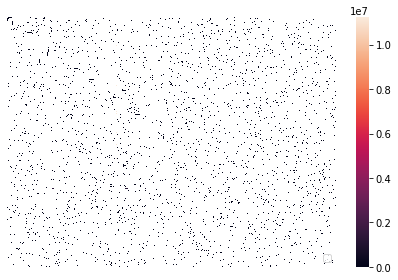

In [10]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(extensionpath + "heatmap.png", dpi=1000, facecolor="white")

In [11]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.0


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


/usr/local/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


0.013798003833696875


0.03790705715966653


0.08014150597508954


0.09051016183458253


11203689.034995273


11203806.241911925


11204631.28125


11207006.242325565


11224241.310740257
